In [18]:
from datetime import datetime, timedelta
import pytz
import math
import pylab as plt

import pandas as pd
import numpy as np

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

%load_ext autoreload

%matplotlib widget
from plotter import Plot
from filewriter import ExcelWriter as ex

from extractor import WeatherExtractor, Extractor, Period

from inversegreyboxmodel import Learner

sampling_interval = '15min' # the interval on which interpolation will be done during preprocessing
n_std_outliers = 3.0 # time the standard deviation and further out, outliers are removed during preprocessing
up_intv = '5min' # up is the upsampling interval that is used in the initial step of processing
gap_n_intv = 11 # the maximum number of consecutive NaNs to fill, i.e. valid measurement values (11+1)* 5 min = 1 hour apart apart will be bridget by interpolation, but not more


# TODO: get list of pseudonyms, (valid) dates and reference parameters from Excel file  

#location: center of Assendorp neighbourhood in Zwolle
lat, lon = 52.5065500000, 6.0996100000

#timezone: 
timezone_homes = 'Europe/Amsterdam'

# first test just a short timeseries
start = pytz.timezone(timezone_homes).localize(datetime(2021, 12, 20))
end = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 18))
homes =  [803422, 805164, 817341, 886307, 873985]

# date and times of seemingly valid periods for short set of 3 
# 886307	2021-12-19 18:55	2022-03-17 09:37
# 873985	2021-12-20 12:54	2022-03-17 17:54
# 817341	2022-01-14 20:27	2022-03-17 18:15

    
# utimately: #min, max dates of the analysis
# start = pytz.timezone(timezone_homes).localize(datetime(2021, 10, 21))
# end = pytz.timezone(timezone_homes).localize(datetime(2022, 5, 12))
# homes = [815925, 817341, 857477, 873985, 879481, 895671, 864296, 845997, 881611, 822479, 831062, 830088, 811308, 809743, 829947, 803422, 886307, 846697, 845966, 839440, 805164, 899510, 897349]
# reversedhomes = [803422, 805164, 809743, 811308, 815925, 817341, 822479, 829947, 830088, 831062, 839440, 845966, 845997, 846697, 857477, 864296, 873985, 879481, 881611, 886307, 895671, 897349, 899510]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
#check whether the datetime object is properly timezone-aware
start

datetime.datetime(2021, 12, 20, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)

In [20]:
#check whether the datetime object is properly timezone-aware
end

datetime.datetime(2022, 1, 18, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)

In [21]:
%%time 
%autoreload 2
# get geospatially interpolated weather from KNMI
# for Twomes, the Weather for all all homes studies can be approached by a single location
# get the dataframe only once for all homes to save time

df_weather = WeatherExtractor.get_interpolated_weather_nl(start, end, lat, lon, timezone_homes, sampling_interval)

Resampling weather data...
CPU times: user 32.8 ms, sys: 2.86 ms, total: 35.6 ms
Wall time: 34.7 ms


In [22]:
df_weather

,outdoor_temp_degC,windspeed_m_per_s,hor_irradiation_J_per_h_per_cm^2,hor_irradiation_W_per_m^2,effective_outdoor_temp_degC
2021-12-20 00:00:00+01:00,6.021051,1.604638,-1.976263e-323,-5.434722e-323,4.951292
2021-12-20 00:15:00+01:00,5.981809,1.604638,-1.976263e-323,-5.434722e-323,4.912050
2021-12-20 00:30:00+01:00,5.942567,1.604638,-1.976263e-323,-5.434722e-323,4.872808
2021-12-20 00:45:00+01:00,5.903324,1.604638,-1.976263e-323,-5.434722e-323,4.833566
2021-12-20 01:00:00+01:00,5.868830,1.583000,-1.976263e-323,-5.434722e-323,4.813496
...,...,...,...,...,...
2022-01-17 23:00:00+01:00,5.782430,2.021638,-1.976263e-323,-5.434722e-323,4.434672
2022-01-17 23:15:00+01:00,5.808976,2.086552,-1.976263e-323,-5.434722e-323,4.417941
2022-01-17 23:30:00+01:00,5.835521,2.151465,-1.976263e-323,-5.434722e-323,4.401211
2022-01-17 23:45:00+01:00,5.862066,2.216379,-1.976263e-323,-5.434722e-323,4.384480


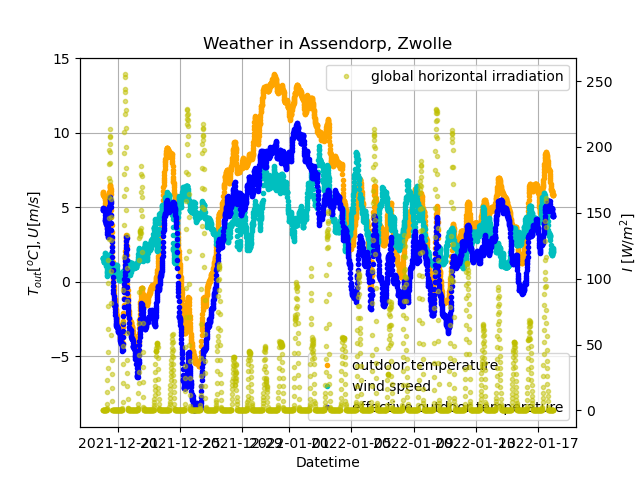

In [23]:
# plot temperature data

Plot.weather_and_other_temperatures('Weather in Assendorp, Zwolle', df_weather)

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [24]:
%%time 
# get interpolated data from the Twomes database and combine with weather data already obtained

df_data_homes = Extractor.get_preprocessed_homes_data(homes, start, end, n_std_outliers, up_intv, gap_n_intv, sampling_interval, timezone_homes, df_weather)

Retrieving data for homes [803422, 805164, 817341, 886307, 873985] from 2021-12-20T00:00:00+01:00 to 2022-01-18T00:00:00+01:00 ...


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.45 s, sys: 54.3 ms, total: 1.5 s
Wall time: 4min 2s


In [25]:
# see what the extracted and interpolated data looks like
df_data_homes

,homepseudonym,outdoor_temp_degC,windspeed_m_per_s,hor_irradiation_J_per_h_per_cm^2,hor_irradiation_W_per_m^2,effective_outdoor_temp_degC,indoor_temp_degC,indoor_temp_degC_CO2,indoor_setpoint_temp_degC,gas_m^3,e_used_normal_kWh,e_used_low_kWh,e_returned_normal_kWh,e_returned_low_kWh,e_used_net_kWh,e_remaining_heat_kWh,timedelta,timedelta_s
2021-12-20 00:00:00+01:00,803422.0,6.021051,1.604638,-1.976263e-323,-5.434722e-323,4.951292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2021-12-20 00:15:00+01:00,803422.0,5.981809,1.604638,-1.976263e-323,-5.434722e-323,4.912050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2021-12-20 00:30:00+01:00,803422.0,5.942567,1.604638,-1.976263e-323,-5.434722e-323,4.872808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2021-12-20 00:45:00+01:00,803422.0,5.903324,1.604638,-1.976263e-323,-5.434722e-323,4.833566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2021-12-20 01:00:00+01:00,803422.0,5.868830,1.583000,-1.976263e-323,-5.434722e-323,4.813496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-17 23:45:00+01:00,873985.0,5.862066,2.216379,-1.976263e-323,-5.434722e-323,4.384480,20.993333,49.500000,NaN,0.0,0.0,0.189,0.0,0.0,0.189,0.189,0 days 00:15:00,900.0
2022-01-18 00:00:00+01:00,873985.0,5.879763,2.259655,-1.976263e-323,-5.434722e-323,4.373327,20.856667,50.533333,NaN,0.0,0.0,0.213,0.0,0.0,0.213,0.213,0 days 00:15:00,900.0
2022-01-18 00:15:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,20.383333,51.366667,NaN,0.0,0.0,0.089,0.0,0.0,0.089,0.089,0 days 00:15:00,900.0
2022-01-18 00:30:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,20.126667,51.800000,NaN,0.0,0.0,0.097,0.0,0.0,0.097,0.097,0 days 00:15:00,900.0


In [26]:
%%time 
%autoreload 2

filename_prefix = datetime.now().astimezone(pytz.timezone('Europe/Amsterdam')).replace(microsecond=0).isoformat().replace(":","")
ex.write(df_data_homes, str('{0}-data_homes-{1}-{2}.xlsx'.format(filename_prefix, start.isoformat(),end.isoformat())))

CPU times: user 9.4 s, sys: 217 ms, total: 9.62 s
Wall time: 9.63 s


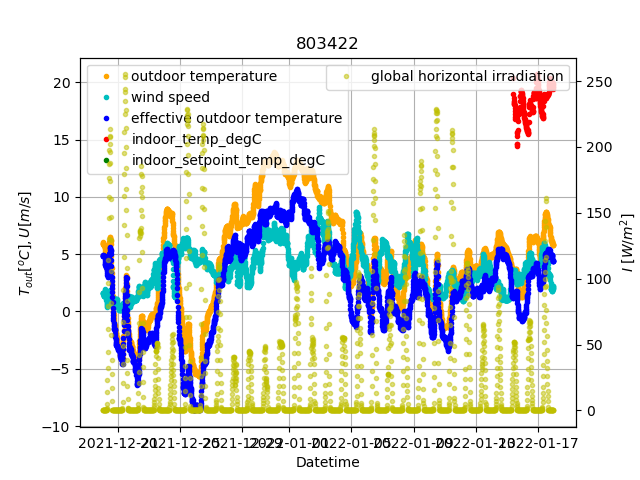

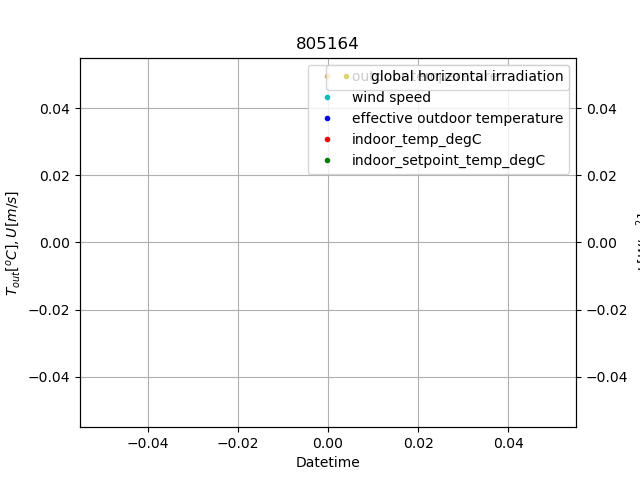

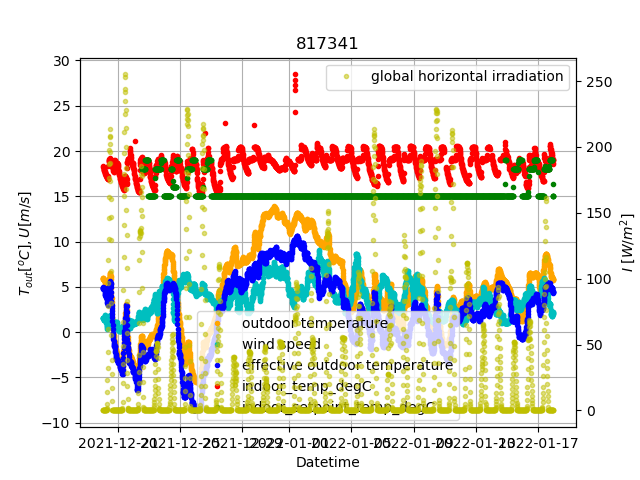

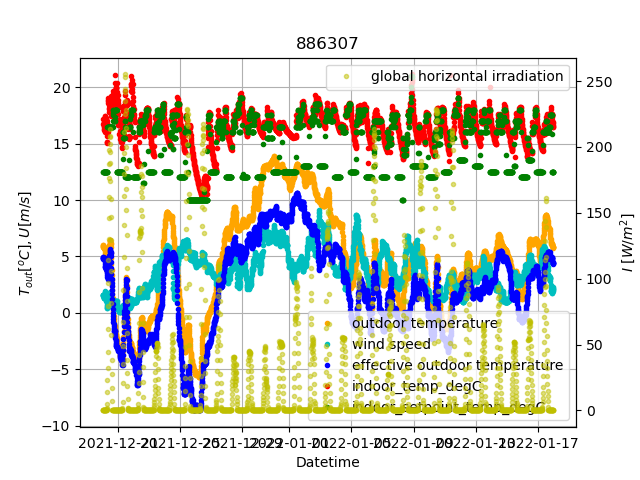

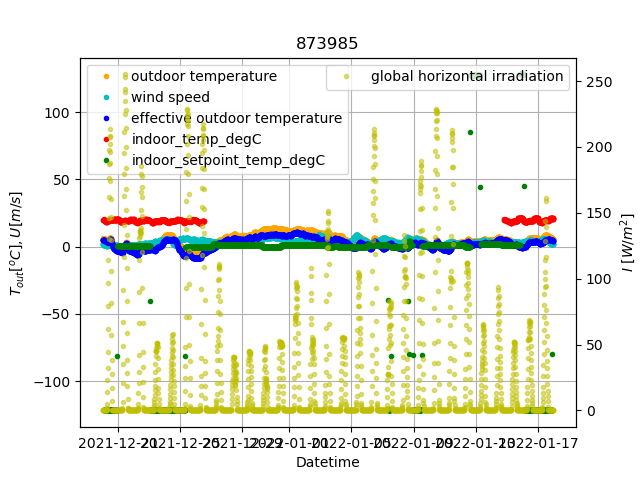

In [35]:
# plot temperature data of multiple homes from an array 
%autoreload 2
for home_id in homes:
    df_data_one_home = df_data_homes[df_data_homes['homepseudonym'] == home_id]
    Plot.weather_and_other_temperatures(home_id, df_data_one_home, [('indoor_temp_degC','r'),('indoor_setpoint_temp_degC','g')])

# # N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks


In [ ]:
# how to select data from a single home
# df_data_homes[df_data_homes['homepseudonym'] == 817341]

In [ ]:
%%time 
%autoreload 2

# uncomment lines below if you need something other than the defaults
# homes_to_analyze = [817341]
start_analysis_period = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 3))
end_analysis_period = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 6))
moving_horizon_duration_d = 3

homes_to_analyze = homes
# start_analysis_period = start
# end_analysis_period = end
# moving_horizon_duration_d = 7

# learn the model parameters and write rerults an intermediate results to excel files
df_results = Learner.learn_home_parameter_moving_horizon(df_data_homes, moving_horizon_duration_d, homes_to_analyze, start_analysis_period, end_analysis_period, showdetails=False)

In [ ]:
#show the results
df_results

In [ ]:
#plot a series of weeks for all homes
# plt.ioff()

# for home_id in homes:
#     df_data_one_home = df_data_homes[df_data_homes['homepseudonym'] == home_id]
#     for moving_horizon_start in pd.date_range(start=start, end=end, inclusive='left', freq='7D'):
#         moving_horizon_end = min(end, moving_horizon_start + timedelta(days=7))
#         df_moving_horizon = df_data_one_home[moving_horizon_start:moving_horizon_end]
#         Plot.weather_and_other_temperatures(home_id, df_moving_horizon, ['indoor_temp_degC'])

# plt.ion()  
    